In [199]:
from TranskribusPyClient.client import TranskribusClient
import os
import re
from datetime import datetime
from dateutil import parser
import numpy as np
import ipyplot

In [2]:
client = TranskribusClient()

In [3]:
client.auth_login(os.getenv('TRANSKRIBUS_USER'), os.getenv('TRANSKRIBUS_PASSWORD'))

/home/rsebastian/.anaconda3/envs/phycor/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transkribus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


True

In [4]:
book = client.getDocById(142978, 951451)

/home/rsebastian/.anaconda3/envs/phycor/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transkribus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [61]:
urls = [(page['pageNr'], page['url'], [ts['url'] for ts in page['tsList']['transcripts']]) for page in book['pageList']['pages']]

In [7]:
result_dir = os.getenv('HOME') + '/code/phycor/data/transkribus'

In [64]:
os.makedirs(result_dir + '/pages', exist_ok=True)
os.makedirs(result_dir + '/page_files', exist_ok=True)

In [65]:
from tqdm import tqdm

In [67]:
for page_nr, page_url, page_xml_urls in tqdm(urls):
    with open(result_dir + '/pages/' + str(page_nr) + '.jpg', 'wb') as f:
        f.write(requests.get(page_url).content)
    for i, page_xml_url in enumerate(page_xml_urls):
        with open(result_dir + '/page_files/' + str(page_nr) + '_' + str(i) + '.xml', 'wb') as f:
            f.write(requests.get(page_xml_url).content)

100%|█████████████████████████████████| 94/94 [04:53<00:00,  3.12s/it]


In [90]:
all_regions_types = {'graphicregion', 'separatorregion', 'tableregion', 'textregion'}

In [ ]:
all_textregion_types = {None, 'paragraph'}

In [76]:
def soup(fn):
    with open(fn) as f:
        return BeautifulSoup(f)


In [17]:
from glob import glob
from PIL import Image
from bs4 import BeautifulSoup

def get_page_data(page_nr):
    image_file = result_dir + '/pages/' + str(page_nr) + '.jpg'
    xml_files = glob(result_dir + '/page_files/' + str(page_nr) + '_*' + '.xml')
    return Image.open(image_file), [soup(f) for f in xml_files]

In [102]:
image, page_files = get_page_data(2)

In [150]:
# image.crop(page_to_pil(page_files[1].find('page').find_all('textregion')[2].find('coords')['points']))

In [387]:
def page_to_pil(points):
    left_upper, _, right_lower, _ = points.split(' ')
    left, upper = tuple(map(int, left_upper.split(',')))
    right, lower = tuple(map(int, right_lower.split(',')))
    return left, upper, right, lower

# image.crop(page_to_pil(region.find('coords')['points']))

In [185]:
def is_ocr(page_soup):
    return 'PyLaia' in page_soup.find('creator').text

def created_at(page_soup):
    return parser.parse(ps.find('created').text)

In [193]:
def get_last_ocr(page_files):
    last_ocr = None
    last_non_ocr = None
    for ps in page_files:
        if is_ocr(ps):
            if last_ocr is None:
                last_ocr = ps
            else:
                if (created_at(ps) > created_at(last_ocr)):
                    last_ocr = ps
        else:
            if last_non_ocr is None:
                last_non_ocr = ps
            else:
                if (created_at(ps) > created_at(last_non_ocr)):
                    last_non_ocr = ps
    return last_ocr, last_non_ocr
        

In [194]:
last_ocr, last_non_ocr = get_last_ocr(page_files)

In [208]:
from sympy import Polygon

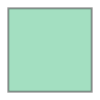

In [210]:
Polygon((0,0), (1,0), (1, 1), (0, 1)).intersection(Poly)

In [218]:
def line_in(textregion, line):
    return polygon(textregion).intersection(polygon(line)).area() / polygon(line).area() > 0.7

In [259]:
def polygon(coords):
    return np.array([[int(a) for a in p.split(',')] for p in coords['points'].split(' ')])

In [339]:
def area(rect):
    ((x_min, y_min), (x_max, y_max)) = rect
    return (x_max - x_min) * (y_max - y_min)

def bound(shape):
    x_max, y_max = np.max(shape, axis=0)
    x_min, y_min = np.min(shape, axis=0)
    return (x_min, y_min), (x_max, y_max)

def how_in(line, textregion):
    line_bound = bound(line)
    (line_x_min, line_y_min), (line_x_max, line_y_max) = line_bound
    (tr_x_min, tr_y_min), (tr_x_max, tr_y_max) = bound(textregion)
    min_x, min_y = max(line_x_min, tr_x_min), max(line_y_min, tr_y_min)
    max_x, max_y = min(line_x_max, tr_x_max), min(line_y_max, tr_y_max)
    if ((max_x - min_x) > 0) and ((max_y - min_y) > 0):
        intersection = ((min_x, min_y), (max_x, max_y))
        return area(intersection) / area(line_bound)
    else:
        return None

In [352]:
def enough_words(lines, threshold):
    count = 0
    for line in lines:
        for word in line.split(' '):
            count += 1
            if count > threshold:
                return True
    return False

In [360]:
def get_lines_in_region(image, page_files):
    word_threshold = 50
    last_ocr, last_non_ocr = get_last_ocr(page_files)
    lines = last_ocr.find_all('textline')
    textregions = [r.find('coords') for r in last_non_ocr.find_all('textregion')]
    lines_in_region = dict()
    for i, region in enumerate(textregions):
        lines_in_region[i] = []
        for line in lines:
            l = polygon(line.find('coords'))
            r = polygon(region)
            overlap = how_in(l, r)
            if overlap and (overlap > 0.90):
                lines_in_region[i].append(line.findChildren('textequiv', recursive=False)[0].find('unicode').text)

    for region in lines_in_region:
        if enough_words(lines_in_region[region], word_threshold):
            crop = image.crop(page_to_pil(textregions[region]['points']))
            text = lines_in_region[region]
            yield crop, text

In [370]:
total_pages = len(glob(result_dir + '/pages/*.jpg'))

In [373]:
paras_dir = result_dir + '/paras/'

In [374]:
from tqdm import tqdm

In [378]:
for i in tqdm(range(total_pages)):
    page_num = i+1
    for para_num, (crop, text) in enumerate(get_lines_in_region(*get_page_data(i + 1))):
        crop.save(paras_dir + str(page_num) + '_' + str(para_num) + '_crop.jpg')
        with open(paras_dir + str(page_num) + '_' + str(para_num) + '_lines.txt', 'w') as f:
            f.write('\n'.join(text))

100%|██████████████████████████████████| 94/94 [00:11<00:00,  8.08it/s]


In [382]:
len(glob(paras_dir+ '*.jpg'))

125

In [386]:
ipyplot.plot_images(glob(paras_dir+ '*.jpg')[30:60])

In [388]:
line_files = glob(paras_dir + '*.txt')
with open([0]

['/home/rsebastian/code/phycor/data/transkribus/paras/42_0_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/46_1_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/43_2_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/57_1_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/48_1_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/42_2_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/48_2_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/85_2_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/77_0_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/27_2_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/81_0_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/8_2_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/33_2_lines.txt',
 '/home/rsebastian/code/phycor/data/transkribus/paras/43_0_lines.txt',
 '/home

In [83]:
# import ipyplot

# ipyplot.plot_images(...)